# Recurrent Neural Network (LSTM)

In [1]:
import numpy as np
import yfinance as yf
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
plt.style.use('ggplot')

In [2]:
ticker = yf.Ticker('GOOG')
df = ticker.history(period = 'max')

In [3]:
begin = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 12, 31)
df = df[begin:end]

In [4]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04,312.304413,313.579620,310.954468,312.204773,3927065,0,0.0
2010-01-05,312.418976,312.747742,309.609497,310.829926,6031925,0,0.0
2010-01-06,311.761444,311.761444,302.047852,302.994293,7987226,0,0.0
2010-01-07,303.562164,303.861053,295.218445,295.940735,12876685,0,0.0
2010-01-08,294.894653,300.498657,293.455048,299.885956,9484016,0,0.0


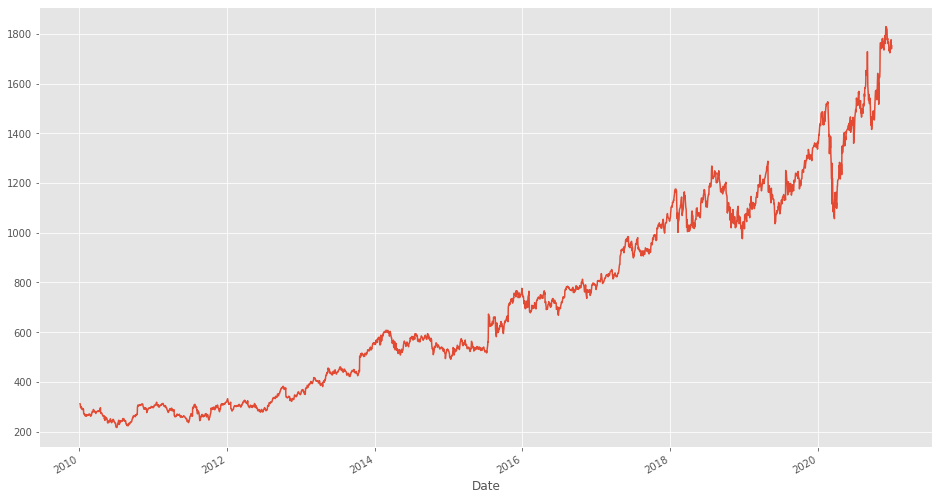

In [5]:
df['Close'].plot(figsize = (16, 9));

In [6]:
train_end = datetime.datetime(2019, 12, 31)
train = df[:train_end]

In [7]:
sc = MinMaxScaler(feature_range = (0, 1))
scaled_train = sc.fit_transform((train['Close'].values).reshape(-1, 1))

In [8]:
period = 60

In [9]:
X_train = []
y_train = []
for i in range(period, len(scaled_train)):
    X_train.append(scaled_train[i-period:i, 0])
    y_train.append(scaled_train[i, 0])

In [10]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [12]:
rnn = Sequential([LSTM(units = 50, activation = 'tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)),
                  Dropout(0.2),
                  LSTM(units = 50, activation = 'tanh', return_sequences = True),
                  Dropout(0.2),
                  LSTM(units = 50, activation = 'tanh', return_sequences = False),
                  Dropout(0.2),
                  Dense(units = 10),
                  Dense(units = 1)
                  ], name = 'rnn_stockpred'
                 )

In [13]:
rnn.summary()

Model: "rnn_stockpred"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 10)              

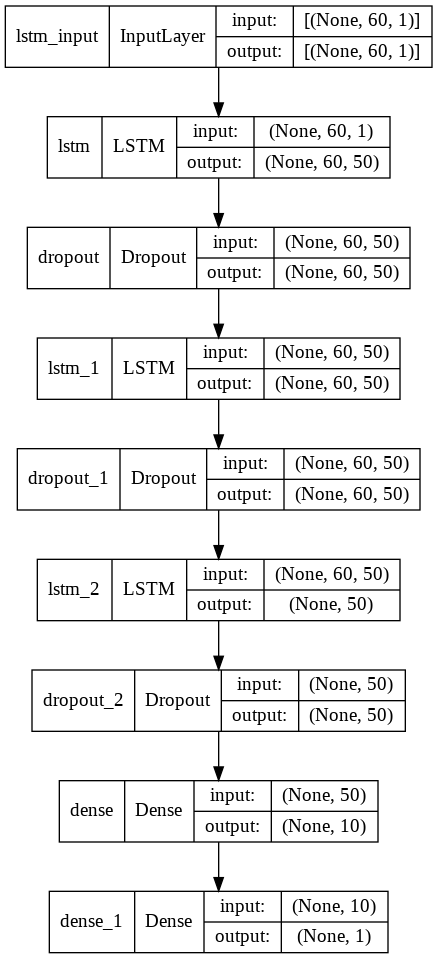

In [14]:
plot_model(rnn, show_shapes = True)

In [15]:
rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [16]:
# rnn.fit(X_train, y_train, epochs = 50, batch_size = 32)

In [17]:
# rnn.save_weights('rnn_stock_price_prediction.h5')
rnn.load_weights('rnn_stock_price_prediction.h5')

In [18]:
test = df['Close'].iloc[len(train) - period :].values

In [19]:
scaled_test = test.reshape(-1,1)
scaled_test = sc.transform(scaled_test)

In [20]:
X_test = []
for i in range(period, len(test)):
    X_test.append(scaled_test[i - period:i, 0])

In [21]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [22]:
y_pred = sc.inverse_transform(rnn.predict(X_test))

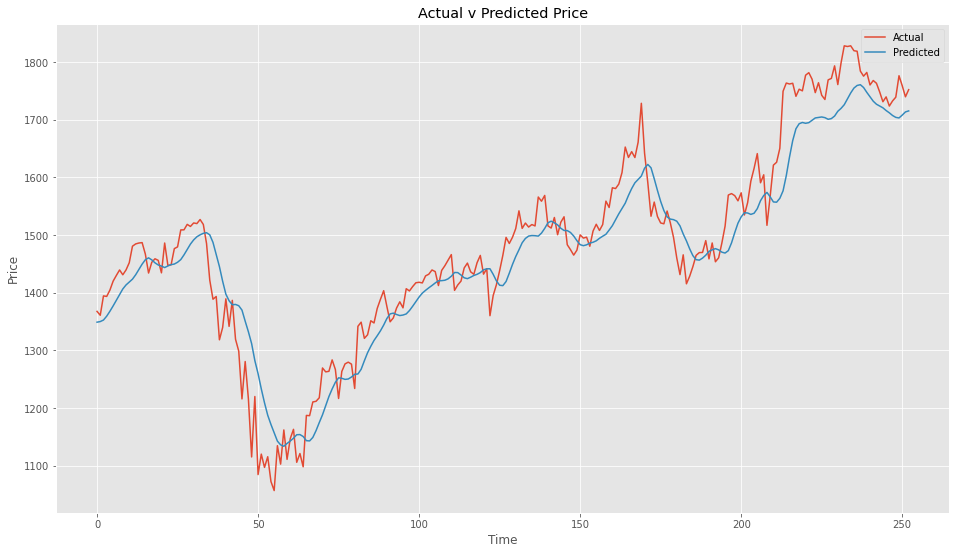

In [23]:
fig = plt.figure(figsize = (16, 9))
plt.plot(test[period:], label = 'Actual')
plt.plot(y_pred, label = 'Predicted')
plt.title('Actual v Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [24]:
rmse = ((y_pred - test[period:])**2).mean()**0.5
print(f'Root Mean Squared Error = {rmse}')

Root Mean Squared Error = 232.7356209121655


<hr>